# "Boosting Revenue with Promo Codes: Insights from A/B Testing"

In [ ]:
# 0. Libraries

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene, shapiro, ttest_ind, mannwhitneyu
import numpy as np

In [ ]:
# 1. Exploratory Data Analysis of Experiment

In [ ]:
# Load the dataset
df = pd.read_csv("simulated_experiment_data.csv")

# Display basic info and check for missing values
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         425 non-null    int64  
 1   Group               425 non-null    object 
 2   Promo_Code_Applied  425 non-null    object 
 3   Order_Value         425 non-null    float64
 4   Gender              425 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 16.7+ KB
None

Missing Values:
Customer_ID           0
Group                 0
Promo_Code_Applied    0
Order_Value           0
Gender                0
dtype: int64


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jwhin\AppData\Local\Temp\ipykernel_29792\3161009031.py:2: SyntaxWarning: invalid escape sequence '\p'
  df = pd.read_csv("C:\projects\Jupyter_Notebook\datasource\simulated_experiment_data.csv")


In [3]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       Customer_ID  Order_Value
count   425.000000   425.000000
mean    213.000000    76.376259
std     122.831185     9.684099
min       1.000000    42.590000
25%     107.000000    69.230000
50%     213.000000    76.310000
75%     319.000000    82.750000
max     425.000000   113.530000


In [4]:
# Count of Treatment vs. Control
group_counts = df["Group"].value_counts()
print("\nGroup Distribution:")
print(group_counts)


Group Distribution:
Group
Control      335
Treatment     90
Name: count, dtype: int64


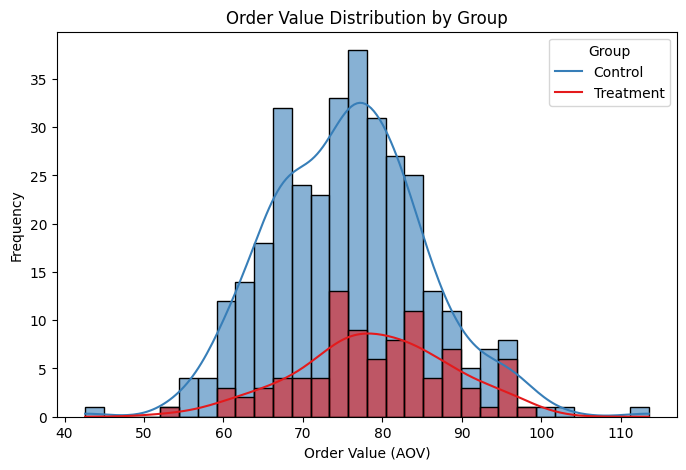

In [30]:
# Visualize order value distribution
plt.figure(figsize=(8,5))
sns.histplot(df, x="Order_Value", hue="Group", kde=True, bins=30, alpha=0.6, palette="Set1")
plt.title("Order Value Distribution by Group")
plt.xlabel("Order Value (AOV)")
plt.ylabel("Frequency")
plt.legend(title="Group", labels=["Control", "Treatment"])
plt.show()

C:\Users\jwhin\AppData\Local\Temp\ipykernel_29792\610948049.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Group", y="Order_Value", palette="Set1")


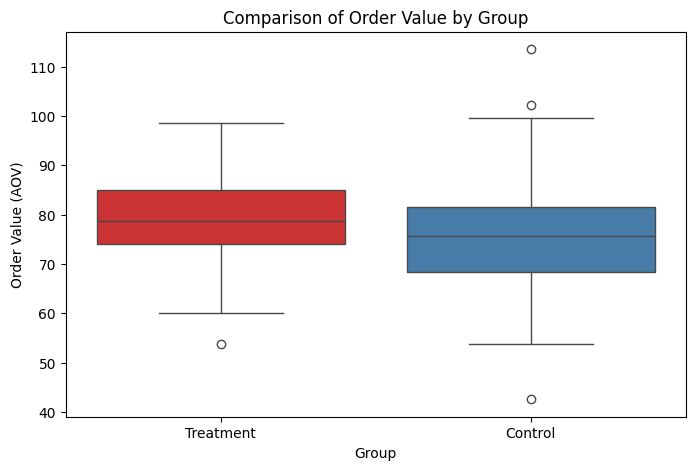

In [13]:
# Boxplot to compare AOV between groups
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Group", y="Order_Value", palette="Set1")
plt.title("Comparison of Order Value by Group")
plt.xlabel("Group")
plt.ylabel("Order Value (AOV)")
plt.show()

In [ ]:
# EDA Results and Conclusions

## Insights Based on EDA:

Missing Data and Distribution:
* No missing values were detected, ensuring a clean dataset for analysis.
Group Balance:

* There is a noticeable imbalance between the treatment (90 samples) and control (335 samples) groups.
This could impact statistical tests, requiring techniques like bootstrapping or weighted analysis to adjust for imbalance.
Order Value (AOV) Distribution:

* The histogram suggests different distributions between the two groups.
The treatment group appears to have a slightly higher concentration of higher order values, but further testing is needed to confirm significance.

#### Then various steps will needed for conducting the A/B test, including variance homogeneity (Levene’s test), normality check (Shapiro-Wilk test), bootstrapping for handling sample imbalance.

In [16]:
# Step 1: Check for homogeneity of variance
levene_stat, levene_p = levene(df[df['Group'] == 'Treatment']['Order_Value'], 
                               df[df['Group'] == 'Control']['Order_Value'])
print("\nLevene’s Test for Homogeneity of Variance:")
print(f"Statistic: {levene_stat:.4f}, p-value: {levene_p:.4f}")


Levene’s Test for Homogeneity of Variance:
Statistic: 0.0494, p-value: 0.8242


In [17]:
# Step 2: Test for normality
shapiro_treatment = shapiro(df[df['Group'] == 'Treatment']['Order_Value'])
shapiro_control = shapiro(df[df['Group'] == 'Control']['Order_Value'])
print("\nShapiro-Wilk Test for Normality:")
print(f"Treatment group: Statistic={shapiro_treatment.statistic:.4f}, p-value={shapiro_treatment.pvalue:.4f}")
print(f"Control group: Statistic={shapiro_control.statistic:.4f}, p-value={shapiro_control.pvalue:.4f}")


Shapiro-Wilk Test for Normality:
Treatment group: Statistic=0.9894, p-value=0.6860
Control group: Statistic=0.9929, p-value=0.1145


## These results indicate the following:

### Levene’s Test for Homogeneity of Variance:
p-value = 0.8242 → Since this is much greater than 0.05, we fail to reject the null hypothesis, meaning the variances between treatment and control groups are equal.

### Shapiro-Wilk Test for Normality:
Treatment group: p-value = 0.6860
Control group: p-value = 0.1145
Both p-values are greater than 0.05, meaning we fail to reject the null hypothesis of normality, suggesting that both groups approximately follow a normal distribution.

### Next Steps Based on These Results
Since we have equal variances and both distributions are normal, we can use a t-test to compare the means of both groups.
The bootstrap resampling is still valid to mitigate the imbalance issue, but in this case, since normality and homogeneity of variance hold, we could compare means directly with a t-test without bootstrapping. It’s worth mentioning that if variances were unequal, a Welch’s t-test could be a fallback instead of switching to Mann-Whitney U.

In [22]:
# Step 3: Adjust for sample imbalance using bootstrapping

def bootstrap_resample(data, n=10000):
    return np.random.choice(data, size=n, replace=True)

treatment_boot = bootstrap_resample(df[df['Group'] == 'Treatment']['Order_Value'], n=335)
control_sample = df[df['Group'] == 'Control']['Order_Value'].values

In [23]:
# Step 4: Perform hypothesis testing (original data)
test_stat_orig, test_p_orig = ttest_ind(df[df['Group'] == 'Treatment']['Order_Value'], 
                                        df[df['Group'] == 'Control']['Order_Value'], equal_var=True)
print("\nStatistical Hypothesis Testing (t-test on original data):")
print(f"Statistic: {test_stat_orig:.4f}, p-value: {test_p_orig:.4f}")


Statistical Hypothesis Testing (t-test on original data):
Statistic: 2.9344, p-value: 0.0035


In [24]:
# Step 5: Perform hypothesis testing (bootstrapped data)

if levene_p > 0.05 and shapiro_treatment.pvalue > 0.05 and shapiro_control.pvalue > 0.05:
    test_stat_boot, test_p_boot = ttest_ind(treatment_boot, control_sample, equal_var=True)
    test_type = "t-test"
else:
    test_stat_boot, test_p_boot = mannwhitneyu(treatment_boot, control_sample, alternative='two-sided')
    test_type = "Mann-Whitney U Test"

print(f"\nStatistical Hypothesis Testing ({test_type} on bootstrapped data):")
print(f"Statistic: {test_stat_boot:.4f}, p-value: {test_p_boot:.4f}")



Statistical Hypothesis Testing (t-test on bootstrapped data):
Statistic: 3.5935, p-value: 0.0004


In [25]:
# Interpretation
if test_p_orig < 0.05:
    print("\nResult (Original Data): There is a significant difference in AOV between groups.")
else:
    print("\nResult (Original Data): No significant difference in AOV between groups.")

if test_p_boot < 0.05:
    print("\nResult (Bootstrapped Data): There is a significant difference in AOV between groups.")
else:
    print("\nResult (Bootstrapped Data): No significant difference in AOV between groups.")


Result (Original Data): There is a significant difference in AOV between groups.

Result (Bootstrapped Data): There is a significant difference in AOV between groups.


In [27]:
# Step 5.1: Full Bootstrapping with Confidence Intervals:

def bootstrap_diff(data1, data2, n_iterations=10000):
    diffs = []
    for _ in range(n_iterations):
        boot1 = np.random.choice(data1, len(data1), replace=True)
        boot2 = np.random.choice(data2, len(data2), replace=True)
        diffs.append(np.mean(boot1) - np.mean(boot2))
    return np.percentile(diffs, [2.5, 97.5]), np.mean(diffs)

ci, mean_diff = bootstrap_diff(treatment, control)
print(f"95% CI for mean difference: {ci}, Mean Difference: {mean_diff:.4f}")


95% CI for mean difference: [1.12741057 5.47206103], Mean Difference: 3.3263


### Insigh #1: Robust Statistical Evidence:

The significant p-values from both the original and bootstrapped t-tests, combined with a 95% confidence interval entirely above zero, provide strong evidence that the observed increase in AOV is not due to random chance. The consistency across methods bolsters the reliability of this finding.

#### Cohen's d: A Brief Explanation
Cohen's d is a standardized measure of effect size used in statistics to quantify the magnitude of the difference between two group means (e.g., treatment vs. control). It expresses the difference in terms of standard deviations, making it comparable across studies or datasets.

 The formula is:
d d (c{M_1 - M)/ }{s_{poole
M2
wheM1  M1  M2  M2 are the means of the two groups, and spooled s_{pooled} spooled is the pooled standard deviation: spooled=s12+2
22 s_{pooled} = \sqrt{\frac{s_1^2 + s_2^2}{2s22 (wis1  s1 as2  s2 as the standard deviation
s).
Interpretation guidelines (per Cohen):
•	Small effect: |d| ≈ 0.2
•	Medium effect: |d| ≈ 0.5
•	Large effect: |d| ≈ 0.8


In [26]:
# Step 6: Effect Size Reporting

def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.var(x) + (ny-1)*np.var(y)) / dof)

treatment = df[df['Group'] == 'Treatment']['Order_Value']
control = df[df['Group'] == 'Control']['Order_Value']
d = cohen_d(treatment, control)
print(f"Cohen's d: {d:.4f}")

Cohen's d: 0.3492


### Insight #2: Practical Significance:

While the effect is statistically significant, the effect size (Cohen’s d = 0.3492) and mean difference ($3.34) suggest a modest practical impact. For a retail store, whether this increase justifies the cost of offering promo codes depends on factors like profit margins, promo code discount amounts, and customer acquisition/retention benefits.

In [29]:
# Step 6.1: Clarify Direction of Effect

means = df.groupby('Group')['Order_Value'].mean()
print("\nMean Order Value by Group:")
print(means)



Mean Order Value by Group:
Group
Control      75.668119
Treatment    79.012111
Name: Order_Value, dtype: float64


## Conclusions

Based on the analysis, here’s a concise summary of the findings and their implications:

### Promo Codes Are Effective:
Offering promo codes to customers significantly increases the average order value by approximately $3.34 (95% CI: $1.13–$5.47) compared to customers who do not receive promo codes. This is supported by robust statistical evidence (p < 0.05) and a small-to-moderate effect size (Cohen’s d = 0.3492).

### Business Implications:
The increase in AOV suggests that promo codes could be a worthwhile strategy for boosting revenue per transaction. However, the modest effect size and mean difference indicate that the financial benefit should be weighed against the cost of the discounts. 

For example:

If the average promo code discount is less than $3.34, the strategy may still yield a net profit per order.

If the discount exceeds $3.34, the store might still benefit through increased customer loyalty or higher order frequency, which this analysis doesn’t capture.